# Simulated Phase Diagram 

In [1]:
# Let the program know where to find your tools file.
import sys
sys.path.append('/home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal/tools/')

In [2]:
# Import necessary packages
from plastid import BAMGenomeArray, VariableFivePrimeMapFactory, \
                        GTF2_TranscriptAssembler, GFF3_TranscriptAssembler, \
                        Transcript, ThreePrimeMapFactory, CenterMapFactory
from plastid.plotting.plots import *
import numpy as np
import os
from Bio import SeqIO
import numpy
import math
import pandas as pd
from statsmodels.stats.proportion import proportions_ztest
from scipy import stats
import keegan_analysis_tools as kat
import TASEP_tools as tt
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
import csv
import random
from matplotlib.pyplot import figure
from scipy.sparse.linalg import lsqr
from multiprocess import Pool
from tqdm import tqdm
from sympy import symbols, solve, sqrt

In [3]:
image_path = '/home/keeganfl/Desktop/Work_Fall_2021/Presentation_figures/'

## define functions

In [4]:
def split_equal(value, parts):
    value = float(value)
    return [i*value/parts for i in range(1,parts+1)]

In [5]:
def det_p_values(ks_table, sections):
    p_values = []
    all_ks = ks_table
    ks_MC = ks_table[ks_table["phase_mutant"] == "MC"]
    for sec, i in zip(sections, list(range(len(sections)))):
        try:
            obs = len(ks_MC.ks_stat[(ks_MC.ks_stat > sec) & (ks_MC.ks_stat < sections[i + 1])])
            all_p = len(all_ks.ks_stat[(all_ks.ks_stat > sec) & (all_ks.ks_stat < sections[i + 1])])
            p_v = proportions_ztest(obs, all_p, len(ks_MC)/len(all_ks))[1]
            p_values.append(p_v)
        except:
            pass
    obs = len(ks_MC.ks_stat[ks_MC.ks_stat > sections[-1]])
    all_p = len(all_ks.ks_stat[all_ks.ks_stat > sections[-1]])
    p_v = proportions_ztest(obs, all_p, len(ks_MC)/len(all_ks))[1]
    p_values.append(p_v)
    return p_values

## Creating phase diagrams and determining how far simulated genes are from elongation limitation

In [35]:
# Create a large series of lists to hold all of the results and intermediate values from out mutant and control samples. 
data_control = []
data_mutant = []
J_control = []
J_mutant = []
phase_control = []
phase_mutant = []
alphas = []
mu_alphas = []
betas = []
mu_betas = []
crit_alphas = []
crit_betas = []
crit_mu_alphas = []
crit_mu_betas = []
min_lambs = []
mu_min_lambs = []
ini_lambs = []
mu_ini_lambs = []
term_lambs = []
mu_term_lambs = []

# Run a large number of simulations using the get_all_intermediates function so that you can save all of the intermediate values. 
for i in range(80):
    length = numpy.random.randint(200,2500)
    alpha = numpy.random.uniform(0.004,0.02)
    x = tt.get_all_intermediates(mean_lambda = 4, sd = 3, length = length, a= alpha, B = 2, read_density = 0.5, pause_N = 7, pause_str = 0.2, 
                         a_frac = 1, elon_frac = 1)
    data_control.append(x[0])
    J_control.append(x[1])
    phase_control.append(x[2])
    alphas.append(x[3])
    betas.append(x[4])
    crit_alphas.append(x[5])
    crit_betas.append(x[6])
    min_lambs.append(x[7])
    ini_lambs.append(x[8])
    term_lambs.append(x[9])
    data_mutant.append(x[10])
    J_mutant.append(x[11])
    phase_mutant.append(x[12])
    mu_alphas.append(x[13])
    mu_betas.append(x[14])
    crit_mu_alphas.append(x[15])
    crit_mu_betas.append(x[16])
    mu_min_lambs.append(x[17])
    mu_ini_lambs.append(x[18])
    mu_term_lambs.append(x[19])

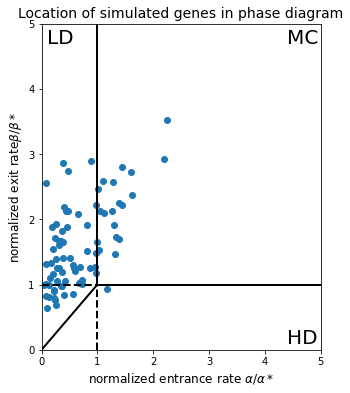

Text(3.4, 0.1, 'HD')

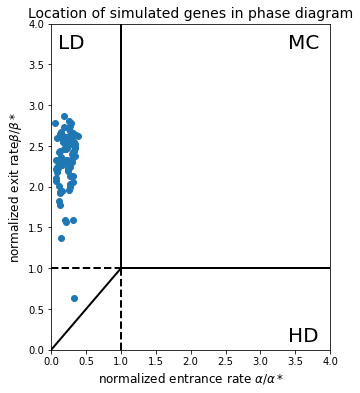

In [39]:
# Create a phase diagram for our mutant sample.
figure(figsize = (5,6))
plt.scatter((np.array(mu_alphas)/np.array(crit_mu_alphas)), (np.array(mu_betas)/np.array(crit_mu_betas))*0.02)
plt.ylim([0,5])
plt.xlim([0,5])
plt.xlabel('normalized entrance rate ' + r'$\alpha / \alpha*$', fontsize = 12)
plt.ylabel('normalized exit rate' + r'$\beta / \beta*$', fontsize = 12)
plt.title("Location of simulated genes in phase diagram", fontsize = 14)
plt.plot([1, 1], [1, 10], 'k-', lw=2)
plt.plot([1, 10], [1,1], 'k-', lw = 2)
plt.plot([0, 1], [0,1], 'k-', lw = 2)
plt.plot([0, 1], [1,1], 'k--', lw = 2)
plt.plot([1, 1], [0,1], 'k--', lw = 2)
plt.text(0.1,4.7, "LD", fontsize = 20)
plt.text(4.4,4.7, "MC", fontsize = 20)
plt.text(4.4,0.1, "HD", fontsize = 20)
plt.savefig(image_path + 'phase_diagram_example.pdf')
plt.show()

# Create a phase diagram for our control sample. 
figure(figsize = (5,6))
plt.scatter((np.array(alphas)/np.array(crit_alphas)), (np.array(betas)/np.array(crit_betas))*0.07)
plt.ylim([0,4])
plt.xlim([0,4])
plt.xlabel('normalized entrance rate ' + r'$\alpha / \alpha*$', fontsize = 12)
plt.ylabel('normalized exit rate' + r'$\beta / \beta*$', fontsize = 12)
plt.title("Location of simulated genes in phase diagram", fontsize = 14)
plt.plot([1, 1], [1, 10], 'k-', lw=2)
plt.plot([1, 10], [1,1], 'k-', lw = 2)
plt.plot([0, 1], [0,1], 'k-', lw = 2)
plt.plot([0, 1], [1,1], 'k--', lw = 2)
plt.plot([1, 1], [0,1], 'k--', lw = 2)
plt.text(0.1,3.7, "LD", fontsize = 20)
plt.text(3.4,3.7, "MC", fontsize = 20)
plt.text(3.4,0.1, "HD", fontsize = 20)

In [8]:
# create a function that can determine the minimum elongation rate necessary to make alpha/crit_alpha equal to 1 (the minimum elongation rate necesary for a phase change)
def get_crit_lambda(alpha, l1, I = 10):
    '''
    This function calculates the minimum elongation rate that would be necessary to make the quotient of alpha divided by the critical alpha equal to one. 
    This means that this function outputs the minimum elongation rate that is necessary for a phase change to occur. 
    '''
    lmin = symbols('lmin', positive = True, real = True)
    expr = ((l1 - (I-1) * (lmin/((1+sqrt(I))**2))) / 2)*(1 - sqrt(1 - (4*l1*(lmin/((1+sqrt(I))**2)))/((l1 - (I - 1)*(lmin/((1+sqrt(I))**2)))**2))) - alpha
    sol = solve(expr)
    return sol

In [9]:
# determine the minimum elongation rate necessary for a phase change for one of our samples.
x = get_crit_lambda(mu_alphas[1],mu_ini_lambs[1])

# determine the difference between the minimum elongation rate necessary for a phase change and the observed minimum elongation rate. 
mu_min_lambs[1]/x[0]

0.750793626476248